<a href="https://colab.research.google.com/github/ducnd58233/scene-text-recognition/blob/main/notebooks/ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OCR

## 0. Download Dataset

In [1]:
!pip install ultralytics
!rm -rf gdrive_downloader.py
!rm -rf memory_tracker.py
!wget 'https://raw.githubusercontent.com/ducnd58233/scene-text-recognition/refs/heads/main/utils/gdrive_downloader.py'
!wget 'https://raw.githubusercontent.com/ducnd58233/scene-text-recognition/refs/heads/main/utils/memory_tracker.py'

import sys
from gdrive_downloader import GDriveDownloader
from memory_tracker import MemoryTracker, safe_to_device

data_dir = './data'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 905.3/905.3 kB 23.0 MB/s eta 0:00:00
--2025-01-07 07:26:56--  https://raw.githubusercontent.com/ducnd58233/scene-text-recognition/refs/heads/main/utils/gdrive_downloader.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10543 (10K) [text/plain]
Saving to: ‘gdrive_downloader.py’

gdrive_downloader.p 100%[===================>]  10.30K  --.-KB/s    in 0s      

2025-01-07 07:26:56 (92.4 MB/s) - ‘gdrive_downloader.py’ saved [10543/10543]

--2025-01-07 07:26:56--  https://raw.githubusercontent.com/ducnd58233/scene-text-recognition/refs/heads/main/utils/memory_tracker.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubuserc

In [2]:
# local
# import sys
# sys.path.append('..')
# from utils.gdrive_downloader import GDriveDownloader
# from utils.memory_tracker import MemoryTracker, safe_to_device

# data_dir = './data'

In [3]:
gdrive_downloader = GDriveDownloader(cache_dir='./cache')
success, message = gdrive_downloader.download_and_extract(
    gdrive_url='https://drive.google.com/file/d/1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV/view?usp=sharing',
    extract_dir=data_dir,
    keep_zip=False,
)
if success:
    print(f'Success: {message}')
else:
    print(f'Error: {message}')

Downloading...
From (original): https://drive.google.com/uc?id=1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV
From (redirected): https://drive.google.com/uc?id=1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV&confirm=t&uuid=6275fccf-c7ef-4920-8930-ae44692db3fb
To: /content/cache/temp_1736234823.zip
100%|██████████| 45.7M/45.7M [00:01<00:00, 26.1MB/s]
Extracting: 100%|██████████| 47.0M/47.0M [00:00<00:00, 66.4MB/s]

Success: Download and extraction completed successfully


In [4]:
import torch.backends.cudnn as cudnn

cudnn.benchmark = False
cudnn.deterministic = True
cudnn.enabled = False

In [5]:
import ultralytics

ultralytics.checks()

Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.7/112.6 GB disk)


## 1. Load data

### Extract from xml

In [6]:
import os
import xml.etree.ElementTree as ET

from typing import List

class ImageInfo:
    def __init__(self, path, size, labels, bboxes):
        self.__path = path
        self.__size = size
        self.__labels = labels
        self.__bboxes = bboxes

    def get_path(self):
        return self.__path

    def get_size(self):
        return self.__size

    def get_labels(self):
        return self.__labels

    def get_label(self, idx):
        return self.__labels[idx]

    def get_bboxes(self):
        return self.__bboxes

    def get_bbox(self, idx):
        return self.__bboxes[idx]

    def __repr__(self):
        s = 'Image info:\n'
        s += f'\tPath: {self.get_path()}\n'
        s += f'\tSize: {self.get_size()}\n'
        s += '\tBBoxes:\n'

        for i in range(len(self.get_labels())):
            s += f'\t\tLabel: {self.get_label(i)} - {self.get_bbox(i)}\n'

        return s


def extract_data_from_xml(root_dir: str) -> List[ImageInfo]:
    xml_path = os.path.join(root_dir, 'words.xml')
    tree = ET.parse(xml_path)
    root = tree.getroot()

    imgs = []

    for img in root:
        bbs_of_img = []
        labels_of_img = []

        for bbs in img.findall('taggedRectangles'):
            for bb in bbs:
                # check tag
                if not bb[0].text or not bb[0].text.isalnum():
                    continue

                bbs_of_img.append(
                    [
                        float(bb.attrib['x']),
                        float(bb.attrib['y']),
                        float(bb.attrib['width']),
                        float(bb.attrib['height']),
                    ]
                )
                labels_of_img.append(bb[0].text.lower())

        img_path = os.path.join(root_dir, img[0].text)
        img_sizes = (int(img[1].attrib['x']), int(img[1].attrib['y']))
        img_info = ImageInfo(img_path, img_sizes, labels_of_img, bbs_of_img)
        imgs.append(img_info)

    return imgs


In [7]:
dataset_dir = 'data/SceneTrialTrain'
imgs = extract_data_from_xml(dataset_dir)
imgs[0]

Image info:
	Path: data/SceneTrialTrain/apanar_06.08.2002/IMG_1261.JPG
	Size: (1600, 1200)
	BBoxes:
		Label: self - [174.0, 392.0, 274.0, 195.0]
		Label: adhesive - [512.0, 391.0, 679.0, 183.0]
		Label: address - [184.0, 612.0, 622.0, 174.0]
		Label: labels - [863.0, 599.0, 446.0, 187.0]
		Label: 36 - [72.0, 6.0, 95.0, 87.0]
		Label: 89m - [247.0, 2.0, 197.0, 88.0]
		Label: cls - [792.0, 0.0, 115.0, 81.0]
		Label: 250 - [200.0, 848.0, 228.0, 139.0]
		Label: on - [473.0, 878.0, 165.0, 109.0]
		Label: a - [684.0, 878.0, 71.0, 106.0]
		Label: roll - [806.0, 844.0, 218.0, 141.0]

### Convert to YOLOv11 format

- YOLO format has 3 main dir: `train`, `test`, `val`. Each contains `images` and `labels` dir

In [8]:
from typing import List

def convert_to_yolo_format(imgs: List[ImageInfo]):
    yolo_data = []

    for img in imgs:
        width, height = img.get_size()
        yolo_labels = []

        for bbox in img.get_bboxes():
            x, y, w, h = bbox

            center_x = (x + w / 2) / width
            center_y = (y + h / 2) / height
            normalized_w = w / width
            normalized_h = h / height

            # have 1 class so class_id set to 0
            class_id = 0

            yolo_label = f'{class_id} {center_x} {center_y} {normalized_w} {normalized_h}'
            yolo_labels.append(yolo_label)

        yolo_data.append((img.get_path(), yolo_labels))

    return yolo_data

In [9]:
class_labels = ['text']
yolo_data = convert_to_yolo_format(imgs)
yolo_data[0]

('data/SceneTrialTrain/apanar_06.08.2002/IMG_1261.JPG',
 ['0 0.194375 0.40791666666666665 0.17125 0.1625',
  '0 0.5321875 0.40208333333333335 0.424375 0.1525',
  '0 0.309375 0.5825 0.38875 0.145',
  '0 0.67875 0.5770833333333333 0.27875 0.15583333333333332',
  '0 0.0746875 0.04125 0.059375 0.0725',
  '0 0.2159375 0.03833333333333333 0.123125 0.07333333333333333',
  '0 0.5309375 0.03375 0.071875 0.0675',
  '0 0.19625 0.7645833333333333 0.1425 0.11583333333333333',
  '0 0.3471875 0.7770833333333333 0.103125 0.09083333333333334',
  '0 0.4496875 0.7758333333333334 0.044375 0.08833333333333333',
  '0 0.571875 0.7620833333333333 0.13625 0.1175'])

In [10]:
# save data for later training

import shutil


def save_data(data, save_dir):
    os.makedirs(save_dir, exist_ok=True)

    os.makedirs(os.path.join(save_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(save_dir, 'labels'), exist_ok=True)

    for image_path, yolo_labels in data:
        shutil.copy(
            image_path,
            os.path.join(save_dir, "images"),
        )

        image_name = os.path.basename(image_path)
        image_name = os.path.splitext(image_name)[0]

        with open(os.path.join(save_dir, 'labels', f'{image_name}.txt'), 'w') as f:
            for label in yolo_labels:
                f.write(f'{label}\n')

In [11]:
from sklearn.model_selection import train_test_split


seed = 0
val_size = 0.2
test_size = 0.125
is_shuffle = True

train_data, test_data = train_test_split(
    yolo_data,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle,
)

test_data, val_data = train_test_split(
    test_data,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle,
)

save_yolo_data_dir =  'datasets/yolo_data'
os.makedirs(save_yolo_data_dir, exist_ok=True)
save_train_dir = os.path.join(save_yolo_data_dir, 'train')
save_val_dir = os.path.join(save_yolo_data_dir, 'val')
save_test_dir = os.path.join(save_yolo_data_dir, 'test')

save_data(train_data, save_train_dir)
save_data(val_data, save_val_dir)
save_data(test_data, save_test_dir)

In [12]:
import yaml


data_yml = {
    'path': 'yolo_data',
    'train': 'train/images',
    'test': 'test/images',
    'val': 'val/images',
    'nc': 1,
    'names': class_labels,
}

yolo_yaml_path = os.path.join(save_yolo_data_dir, 'data.yml')
with open(yolo_yaml_path, 'w') as f:
    yaml.dump(data_yml, f, default_flow_style=False)

## 2. Model

In [14]:
from ultralytics import YOLO

MemoryTracker.clear_memory()

model = YOLO('yolo11m.pt')

results = model.train(
    data=yolo_yaml_path,
    epochs=100,
    imgsz=640,
    # device='cpu',
    # workers=2,
    cache=True,
    patience=20,
    plots=True
)

Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11m.pt, data=datasets/yolo_data/data.yml, epochs=100, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=True, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxe

100%|██████████| 5.35M/5.35M [00:00<00:00, 97.7MB/s]


AMP: checks passed ✅


train: Scanning /content/datasets/yolo_data/train/labels.cache... 200 images, 7 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



train: Caching images (0.2GB RAM): 100%|██████████| 200/200 [00:01<00:00, 156.31it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/datasets/yolo_data/val/labels... 7 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7/7 [00:00<00:00, 1540.41it/s]

val: New cache created: /content/datasets/yolo_data/val/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 7/7 [00:00<00:00, 43.23it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      8.63G      2.139      3.168      1.885         53        640: 100%|██████████| 13/13 [00:17<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.18s/it]

                   all          7         62      0.309      0.371      0.252      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      8.56G      1.201      1.262       1.15         55        640: 100%|██████████| 13/13 [00:16<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.31it/s]

                   all          7         62      0.277      0.371      0.208     0.0906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      8.63G      1.178      1.202      1.132         26        640: 100%|██████████| 13/13 [00:16<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]

                   all          7         62   0.000476     0.0161   0.000242   0.000169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      8.58G      1.222      1.217      1.193         59        640: 100%|██████████| 13/13 [00:18<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.07it/s]

                   all          7         62    0.00589     0.0323     0.0019   0.000372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      8.63G      1.232       1.18      1.186         63        640: 100%|██████████| 13/13 [00:18<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.27it/s]

                   all          7         62    0.00305     0.0968    0.00168   0.000292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      8.65G      1.324      1.256      1.223         69        640: 100%|██████████| 13/13 [00:16<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


                   all          7         62    0.00459      0.129    0.00329    0.00144

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      8.58G      1.361      1.386      1.268         41        640: 100%|██████████| 13/13 [00:16<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]

                   all          7         62    0.00551      0.145    0.00782    0.00379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      8.65G       1.36      1.279       1.27         54        640: 100%|██████████| 13/13 [00:26<00:00,  2.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]

                   all          7         62     0.0309       0.29     0.0187    0.00683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      8.57G      1.366      1.152      1.248         39        640: 100%|██████████| 13/13 [00:19<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.58it/s]

                   all          7         62     0.0256     0.0968    0.00582      0.002



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      8.63G      1.402      1.172       1.24         88        640: 100%|██████████| 13/13 [00:18<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

                   all          7         62        0.2     0.0645     0.0314    0.00888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      8.71G      1.341       1.16      1.216         38        640: 100%|██████████| 13/13 [00:20<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

                   all          7         62      0.297      0.403      0.213     0.0715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100       8.6G       1.31      1.031      1.229         46        640: 100%|██████████| 13/13 [00:17<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]

                   all          7         62      0.198      0.419      0.207     0.0938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      8.59G      1.251      1.018      1.173         69        640: 100%|██████████| 13/13 [00:17<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.72it/s]


                   all          7         62      0.205      0.387      0.178      0.091

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      8.63G      1.229      1.046      1.175         35        640: 100%|██████████| 13/13 [00:16<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.91it/s]


                   all          7         62      0.274      0.407       0.29      0.148

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      8.65G      1.217     0.9796      1.159         26        640: 100%|██████████| 13/13 [00:16<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]


                   all          7         62      0.251      0.661      0.279      0.147

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      8.62G      1.132     0.9627       1.15         36        640: 100%|██████████| 13/13 [00:18<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.11it/s]

                   all          7         62      0.204      0.661      0.227      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      8.59G      1.151      0.947      1.164         95        640: 100%|██████████| 13/13 [00:17<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

                   all          7         62      0.334      0.355      0.259      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      8.63G      1.185     0.9542      1.171         79        640: 100%|██████████| 13/13 [00:17<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]

                   all          7         62      0.472      0.491      0.395      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      8.62G      1.096      0.873      1.122         83        640: 100%|██████████| 13/13 [00:19<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]

                   all          7         62      0.531      0.435      0.469      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      8.62G      1.117     0.9291      1.135         46        640: 100%|██████████| 13/13 [00:18<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]

                   all          7         62      0.389      0.371      0.376      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      8.53G      1.083     0.8804      1.108         54        640: 100%|██████████| 13/13 [00:18<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.58it/s]

                   all          7         62       0.43      0.677      0.518      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      8.65G      1.034     0.8551      1.078         38        640: 100%|██████████| 13/13 [00:16<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.37it/s]

                   all          7         62      0.455      0.403      0.441      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      8.65G       1.12     0.8862      1.137         30        640: 100%|██████████| 13/13 [00:24<00:00,  1.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all          7         62      0.671       0.29      0.373      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      8.65G      1.053     0.8681      1.101         53        640: 100%|██████████| 13/13 [00:22<00:00,  1.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]

                   all          7         62      0.535      0.687      0.551      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      8.56G     0.9949     0.8083      1.073         59        640: 100%|██████████| 13/13 [00:18<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all          7         62      0.594      0.452      0.418      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100       8.7G      1.012     0.8238      1.074         92        640: 100%|██████████| 13/13 [00:18<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

                   all          7         62      0.575      0.484      0.473      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      8.62G      1.006     0.8117       1.07         32        640: 100%|██████████| 13/13 [00:16<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all          7         62      0.519      0.613      0.509      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      8.63G     0.9844     0.7812      1.061         61        640: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

                   all          7         62      0.829      0.468      0.643      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      8.57G     0.9934     0.7802      1.075         32        640: 100%|██████████| 13/13 [00:17<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]

                   all          7         62      0.526      0.645      0.607      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      8.63G      1.018     0.7764      1.065         76        640: 100%|██████████| 13/13 [00:20<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

                   all          7         62      0.556      0.597      0.536      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      8.62G      1.001     0.7497      1.065         58        640: 100%|██████████| 13/13 [00:20<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]

                   all          7         62      0.633      0.516      0.553      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      8.63G     0.9557     0.7387      1.045         64        640: 100%|██████████| 13/13 [00:20<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

                   all          7         62      0.638      0.516      0.534      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      8.57G     0.9743     0.7801      1.061         72        640: 100%|██████████| 13/13 [00:17<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


                   all          7         62      0.596      0.595      0.596      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      8.63G     0.9406     0.7435      1.035         58        640: 100%|██████████| 13/13 [00:20<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.21it/s]

                   all          7         62      0.578      0.677      0.648      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      8.65G      0.987     0.7599      1.065         68        640: 100%|██████████| 13/13 [00:20<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

                   all          7         62      0.708      0.597      0.591      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      8.65G      0.891     0.7248      1.025         67        640: 100%|██████████| 13/13 [00:17<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]

                   all          7         62      0.624      0.645      0.599      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      8.56G     0.9271     0.7538      1.033         39        640: 100%|██████████| 13/13 [00:15<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

                   all          7         62      0.546       0.62      0.566      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      8.64G     0.9842     0.7335      1.036         79        640: 100%|██████████| 13/13 [00:17<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all          7         62      0.603      0.581      0.607       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      8.62G     0.8859     0.6924      1.024         68        640: 100%|██████████| 13/13 [00:20<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]

                   all          7         62      0.708      0.613      0.678      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      8.64G      0.896     0.6979      1.013         49        640: 100%|██████████| 13/13 [00:16<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.29it/s]

                   all          7         62      0.724      0.645      0.727      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      8.56G     0.8708       0.69      1.009         56        640: 100%|██████████| 13/13 [00:16<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.08it/s]


                   all          7         62      0.743      0.645      0.714      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      8.64G     0.8717     0.7108     0.9995         29        640: 100%|██████████| 13/13 [00:16<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.21it/s]

                   all          7         62      0.628      0.661       0.63      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      8.64G     0.8632     0.6737      1.008         40        640: 100%|██████████| 13/13 [00:16<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.27it/s]

                   all          7         62      0.812      0.628      0.657      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      8.59G     0.8054     0.6161     0.9876         53        640: 100%|██████████| 13/13 [00:15<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all          7         62      0.842      0.685      0.759      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      8.56G     0.8184     0.6127     0.9911         38        640: 100%|██████████| 13/13 [00:16<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]

                   all          7         62      0.777      0.729      0.773      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      8.62G     0.8382      0.626       0.98         50        640: 100%|██████████| 13/13 [00:16<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

                   all          7         62      0.731      0.742      0.765      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      8.65G       0.82     0.6318     0.9867         53        640: 100%|██████████| 13/13 [00:17<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]

                   all          7         62      0.755      0.697      0.739      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      8.65G     0.8463     0.6202      1.007         44        640: 100%|██████████| 13/13 [00:15<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.48it/s]

                   all          7         62      0.828      0.645      0.779      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      8.59G     0.7939       0.59      0.975         80        640: 100%|██████████| 13/13 [00:15<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]

                   all          7         62       0.89      0.661      0.802      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      8.63G     0.7975     0.5943      1.005         44        640: 100%|██████████| 13/13 [00:15<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.24it/s]

                   all          7         62      0.858       0.71      0.791      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      8.64G     0.7891     0.5986     0.9934         24        640: 100%|██████████| 13/13 [00:16<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]


                   all          7         62      0.773      0.742      0.732      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      8.63G     0.8387     0.6025     0.9701         61        640: 100%|██████████| 13/13 [00:16<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.22it/s]

                   all          7         62      0.654      0.694      0.687      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      8.58G     0.8305     0.5946     0.9835         36        640: 100%|██████████| 13/13 [00:16<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]


                   all          7         62      0.839      0.548      0.725      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      8.63G     0.8087     0.6061     0.9859         67        640: 100%|██████████| 13/13 [00:15<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


                   all          7         62      0.686      0.661      0.727      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      8.66G     0.7736     0.5941      0.976         52        640: 100%|██████████| 13/13 [00:15<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.27it/s]

                   all          7         62      0.694      0.645        0.7      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      8.63G     0.7746     0.5863     0.9593         70        640: 100%|██████████| 13/13 [00:16<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.41it/s]

                   all          7         62      0.818      0.645      0.741      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      8.57G     0.7736     0.5656      0.966        103        640: 100%|██████████| 13/13 [00:16<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.17it/s]


                   all          7         62      0.808      0.645      0.738      0.472

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      8.64G     0.7947     0.5716     0.9757         52        640: 100%|██████████| 13/13 [00:16<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.69it/s]


                   all          7         62      0.773      0.605      0.687       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      8.63G     0.8091     0.5804     0.9807         57        640: 100%|██████████| 13/13 [00:16<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.12it/s]

                   all          7         62      0.692      0.653       0.73      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      8.64G     0.7836     0.5822     0.9862         58        640: 100%|██████████| 13/13 [00:16<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


                   all          7         62      0.855      0.597      0.765      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      8.59G     0.8165     0.5974      1.018         32        640: 100%|██████████| 13/13 [00:16<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.12it/s]


                   all          7         62      0.664      0.764      0.698       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      8.63G     0.7863     0.5591     0.9772         68        640: 100%|██████████| 13/13 [00:15<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.09it/s]

                   all          7         62      0.677      0.758       0.76      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      8.64G     0.7692     0.5422     0.9488         73        640: 100%|██████████| 13/13 [00:23<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

                   all          7         62      0.707      0.694      0.767      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      8.64G     0.7655     0.5327     0.9734         36        640: 100%|██████████| 13/13 [00:20<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]

                   all          7         62       0.59      0.726      0.713      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      8.58G     0.7747     0.5647     0.9706         39        640: 100%|██████████| 13/13 [00:18<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]

                   all          7         62      0.707      0.613      0.732      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      8.65G     0.7442     0.5258     0.9605         44        640: 100%|██████████| 13/13 [00:18<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]

                   all          7         62      0.741      0.693      0.728      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      8.65G     0.7672     0.5429     0.9649         36        640: 100%|██████████| 13/13 [00:16<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]

                   all          7         62      0.697      0.668      0.734      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      8.62G     0.7674     0.5166     0.9644         40        640: 100%|██████████| 13/13 [00:15<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.04it/s]

                   all          7         62       0.66      0.726      0.669      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      8.56G     0.7474     0.5229     0.9606         42        640: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]

                   all          7         62      0.815      0.639      0.731      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      8.65G     0.7141     0.5196     0.9615         31        640: 100%|██████████| 13/13 [00:17<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]

                   all          7         62      0.824      0.629      0.725      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      8.64G      0.716     0.5208      0.946         84        640: 100%|██████████| 13/13 [00:15<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]

                   all          7         62      0.673      0.697      0.694      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      8.63G     0.7076     0.5159     0.9467         54        640: 100%|██████████| 13/13 [00:15<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]

                   all          7         62      0.644      0.742      0.707      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      8.57G     0.7052     0.5025     0.9312         51        640: 100%|██████████| 13/13 [00:16<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]


                   all          7         62      0.769      0.565      0.665      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      8.63G     0.7269     0.5133     0.9493         48        640: 100%|██████████| 13/13 [00:15<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.83it/s]

                   all          7         62      0.792      0.677      0.757      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      8.63G     0.6815     0.5024     0.9396         74        640: 100%|██████████| 13/13 [00:16<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.42it/s]

                   all          7         62      0.696      0.806      0.793      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      8.63G     0.7196     0.5071     0.9465         55        640: 100%|██████████| 13/13 [00:16<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]

                   all          7         62      0.684      0.734      0.733        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      8.57G     0.6875      0.501     0.9449        101        640: 100%|██████████| 13/13 [00:16<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.27it/s]

                   all          7         62      0.697      0.706      0.733      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      8.64G     0.6569     0.4647     0.9322         45        640: 100%|██████████| 13/13 [00:16<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.07it/s]

                   all          7         62       0.64      0.806      0.732      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      8.65G     0.6788     0.4703       0.93         59        640: 100%|██████████| 13/13 [00:16<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


                   all          7         62      0.666      0.771      0.742      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      8.59G     0.6763     0.4718     0.9267         42        640: 100%|██████████| 13/13 [00:16<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.35it/s]

                   all          7         62       0.68      0.774      0.756      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      8.56G     0.6743     0.4711     0.9331         49        640: 100%|██████████| 13/13 [00:15<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.51it/s]

                   all          7         62      0.647      0.769      0.735      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      8.62G     0.7153     0.4695     0.9515         58        640: 100%|██████████| 13/13 [00:15<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.27it/s]

                   all          7         62      0.623      0.726      0.712      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      8.63G     0.6678     0.4568     0.9223         61        640: 100%|██████████| 13/13 [00:16<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.30it/s]

                   all          7         62      0.574      0.758      0.686      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      8.64G     0.6727     0.4703     0.9413         44        640: 100%|██████████| 13/13 [00:16<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.07it/s]


                   all          7         62      0.633      0.758      0.717      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      8.56G     0.6349     0.4453     0.9178         85        640: 100%|██████████| 13/13 [00:15<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.24it/s]


                   all          7         62      0.845      0.615      0.744      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      8.64G     0.6393     0.4506      0.933         38        640: 100%|██████████| 13/13 [00:16<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]

                   all          7         62      0.904      0.608      0.751      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      8.63G     0.6671     0.4419     0.9138         53        640: 100%|██████████| 13/13 [00:23<00:00,  1.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all          7         62       0.84      0.645      0.762      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      8.62G      0.647     0.4375     0.9298         45        640: 100%|██████████| 13/13 [00:18<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


                   all          7         62      0.683      0.765      0.762       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      8.57G     0.6335     0.4351     0.9073         91        640: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

                   all          7         62       0.65       0.75      0.767      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      8.65G     0.6253     0.4173     0.9132         55        640: 100%|██████████| 13/13 [00:19<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

                   all          7         62      0.678      0.758      0.775      0.515


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      8.63G     0.6892     0.4723     0.9207         47        640: 100%|██████████| 13/13 [00:22<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.74it/s]

                   all          7         62        0.7      0.752      0.766      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      8.63G     0.6721     0.4832     0.9148         50        640: 100%|██████████| 13/13 [00:20<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]

                   all          7         62      0.685      0.737      0.759       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      8.55G     0.6404     0.4527     0.8997         19        640: 100%|██████████| 13/13 [00:17<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.06it/s]


                   all          7         62      0.688      0.726      0.758      0.541

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      8.61G      0.655      0.454     0.9003         55        640: 100%|██████████| 13/13 [00:20<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all          7         62      0.673      0.774       0.79      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      8.63G     0.6665     0.4529        0.9         29        640: 100%|██████████| 13/13 [00:18<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]

                   all          7         62      0.664      0.774      0.767      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      8.65G      0.656     0.4623     0.9127         19        640: 100%|██████████| 13/13 [00:17<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.35it/s]

                   all          7         62      0.653      0.742      0.752      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      8.56G     0.6319      0.441     0.9047         33        640: 100%|██████████| 13/13 [00:22<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.88it/s]


                   all          7         62      0.686      0.726      0.739      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      8.63G     0.6493      0.445     0.9195         28        640: 100%|██████████| 13/13 [00:17<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


                   all          7         62      0.667       0.71      0.742      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      8.63G       0.63      0.454     0.9009         18        640: 100%|██████████| 13/13 [00:17<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all          7         62      0.673       0.71      0.737      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      8.63G     0.6056     0.4178     0.8871         36        640: 100%|██████████| 13/13 [00:17<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all          7         62      0.685       0.71       0.74      0.527



100 epochs completed in 0.545 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 40.5MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11m summary (fused): 303 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.74it/s]


                   all          7         62      0.675      0.774      0.789      0.541
Speed: 0.2ms preprocess, 18.4ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train2


In [17]:
from ultralytics import YOLO

model_path = './runs/detect/train2/weights/best.pt'
model = YOLO(model_path)

metrics = model.eval()
metrics

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(192, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, track_

# Text Recognition

## 0. Load data

In [19]:
import os
import random
import time

import cv2
import matplotlib.pyplot as plt
import numpy as np
import timm
import torch
import torch.nn as nn
import torchvision
from typing import List
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

In [27]:
def split_bbxes(imgs: List[ImageInfo], save_dir):
    os.makedirs(save_dir, exist_ok=True)
    count = 0
    labels = []

    for img_info in imgs:
        img = Image.open(img_info.get_path())

        for label, bbox in zip(img_info.get_labels(), img_info.get_bboxes()):
            x, y, w, h = bbox
            cropped_img = img.crop((x, y, x + w, y + h))

            if np.mean(cropped_img) < 35 or np.mean(cropped_img) > 220:
                continue

            if cropped_img.size[0] < 10 or cropped_img.size[1] < 10:
                continue

            filename = f'{count:06d}.jpg'
            new_img_path = os.path.join(save_dir, filename)

            cropped_img.save(new_img_path)
            label = new_img_path + '\t' + label

            labels.append(label)
            count += 1

    print(f'Created {count} images')
    with open(os.path.join(save_dir, 'labels.txt'), 'w', encoding='utf-8') as f:
        for label in labels:
            f.write(f'{label}\n')



In [28]:
save_dir = 'datasets/ocr_dataset'
split_bbxes(imgs, save_dir)

Created 1093 images


In [30]:
img_paths = []
labels = []

with open(os.path.join(save_dir, 'labels.txt'), 'r', encoding='utf-8') as f:
    for label in f:
        labels.append(label.split('\t')[1].strip())
        img_paths.append(label.split('\t')[0].strip())

print(f'Total images: {len(img_paths)}')

Total images: 1093


## 1. Build vocabulary

In [31]:
letters = [char.split('.')[0].lower() for char in labels]
letters = ''.join(letters)
letters = sorted(list(set(list(letters))))

chars = ''.join(letters)
blank_char = '-'
chars += blank_char
vocab_size = len(chars)

print(f'Vocab: {chars}')
print(f'Vocab size: {vocab_size}')


Vocab: 0123456789abcdefghijklmnopqrstuvwxyzéñ-
Vocab size: 39


In [32]:
char_to_idx = {char: idx + 1 for idx, char in enumerate(sorted(chars))}
idx_to_char = {index: char for char, index in char_to_idx.items()}

In [33]:
# convert string to vector of char idx (token)
max_label_len = max([len(label) for label in labels])

def encode(label, char_to_idx, max_label_len):
    encoded_labels = torch.tensor(
        [char_to_idx[char] for char in label],
        dtype=torch.int32
    )
    label_len = len(encoded_labels)
    lengths = torch.tensor(
        label_len,
        dtype=torch.int32
    )
    padded_labels = F.pad(
        encoded_labels,
        (0, max_label_len - label_len)
    )
    return padded_labels, lengths

def decode(encoded_sequences, idx_to_char, blank_char='-'):
    decoded_sequences = []

    for seq in encoded_sequences:
        decoded_label = []
        prev_char = None

        for token in seq:
            if token == 0: # ignore padding (token = 0)
                continue

            char = idx_to_char[token.item()]
            if char == blank_char and char == prev_char:
                continue

            decoded_label.append(char)
            prev_char = char

        decoded_sequences.append(''.join(decoded_label))

    print(f'From {encoded_sequences} to {decoded_sequences}')
    return decoded_sequences


## 2. Preprocess data

In [34]:
data_transforms = {
    'train': transforms.Compose(
        [
            transforms.Resize((100, 420)),
            transforms.ColorJitter(
                brightness=0.5,
                contrast=0.5,
                saturation=0.5,
            ),
            transforms.Grayscale(
                num_output_channels=1,
            ),
            transforms.GaussianBlur(3),
            transforms.RandomAffine(
                degrees=1,
                shear=1,
            ),
            transforms.RandomPerspective(
                distortion_scale=0.5,
                p=0.5,
                interpolation=3,
            ),
            transforms.RandomRotation(degrees=2),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5)),
        ]
    ),
    'val': transforms.Compose(
      [
          transforms.Resize((100, 420)),
          transforms.Grayscale(
              num_output_channels=1,
          ),
          transforms.ToTensor(),
          transforms.Normalize((0.5,), (0.5)),
      ]
    ),
}

In [36]:
seed = 0
val_size = 0.1
test_size = 0.1
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    img_paths,
    labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle,
)
X_train, X_test, y_train_, y_test = train_test_split(
    X_train,
    y_train,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle,
)

In [37]:
class STRDataset(Dataset):
    def __init__(self, X, y, char_to_idx, max_label_len, label_encoder=None, transform=None):
        self.img_paths = X
        self.labels = y
        self.char_to_idx = char_to_idx
        self.max_label_len = max_label_len
        self.label_encoder = label_encoder
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        if self.label_encoder:
            encoded_label, label_len = self.label_encoder(label, self.char_to_idx, self.max_label_len)

        return img, encoded_label, label_len

In [39]:
train_dataset = STRDataset(
    X_train,
    y_train,
    char_to_idx,
    max_label_len,
    label_encoder=encode,
    transform=data_transforms['train'],
)
val_dataset = STRDataset(
    X_val,
    y_val,
    char_to_idx,
    max_label_len,
    label_encoder=encode,
    transform=data_transforms['val'],
)
test_dataset = STRDataset(
    X_test,
    y_test,
    char_to_idx,
    max_label_len,
    label_encoder=encode,
    transform=data_transforms['val'],
)

train_batch_size = 64
test_batch_size = 64 * 2

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

## 3. Model

In [42]:
class CRNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        hidden_size,
        n_layers,
        dropout=0.2,
        unfreeze_layers=3
    ):
        super(CRNN, self).__init__()

        backbone = timm.create_model('resnet152', in_chans=1, pretrained=True)
        modules = list(backbone.children())[:-2]
        modules.append(nn.AdaptiveAvgPool2d((1, None)))
        self.backbone = nn.Sequential(*modules)

        # Unfreeze last few layers
        for param in self.backbone[-unfreeze_layers:].parameters():
            param.requires_grad = True

        self.map_seq = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.gru = nn.GRU(
            input_size=512,
            hidden_size=hidden_size,
            num_layers=n_layers,
            dropout=dropout if n_layers > 1 else 0,
            bidirectional=True,
            batch_first=True,
        )
        self.layer_norm = nn.LayerNorm(hidden_size * 2)
        self.out = nn.Sequential(
            nn.Linear(hidden_size * 2, vocab_size),
            nn.LogSoftmax(dim=2)
        )

    @torch.autocast(device_type='cuda')
    def forward(self, x):
        x = self.backbone(x)
        x = x.permute(0, 3, 1, 2)
        x = x.view(x.size(0), x.size(1), -1) # Flatten feature map
        x = self.map_seq(x)
        x, _ = self.gru(x)
        x = self.layer_norm(x)
        x = self.out(x)
        x = x.permute(1, 0, 2) # Based on CTC

        return x

In [43]:
hidden_size = 256
n_layers = 3
dropout = 0.2
unfreeze_layers = 3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CRNN(
    vocab_size=vocab_size,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout=dropout,
    unfreeze_layers=unfreeze_layers,
).to(device)

## 3. Training & Evaluating

In [47]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for batch in dataloader:
            images, labels, label_lengths = batch
            images = images.to(device)
            labels = labels.to(device)
            label_lengths = label_lengths.to(device)

            outputs = model(images)
            logits_lens = torch.full(
                size=(outputs.size(1),),
                fill_value=outputs.size(0),
                dtype=torch.long
            )
            loss = criterion(outputs, labels, logits_lens, label_lengths)
            losses.append(loss.item())
    loss = sum(losses) / len(losses)
    return loss

def fit(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs, device):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        start = time.time()
        batch_train_losses = []

        model.train()
        for batch in train_loader:
            images, labels, label_lengths = batch
            images = images.to(device)
            labels = labels.to(device)
            label_lengths = label_lengths.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            logits_lens = torch.full(
                size=(outputs.size(1),),
                fill_value=outputs.size(0),
                dtype=torch.long
            ).to(device)

            loss = criterion(outputs, labels, logits_lens, label_lengths)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()
            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        val_loss = evaluate(model, val_loader, criterion, device)
        scheduler.step(val_loss)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(
            f'Epoch {epoch + 1}/{epochs}, '
            f'Train loss: {train_loss:.4f}, '
            f'Val loss: {val_loss:.4f}, '
            f'Time: {time.time() - start:.2f}s'
        )
    return train_losses, val_losses

In [48]:
epochs = 10
lr = 5e-4
weight_decay = 1e-5
scheduler_step_size = epochs * 0.5

criterion = nn.CTCLoss(
    blank=char_to_idx[blank_char],
    zero_infinity=True,
    reduction='mean',
)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay,
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=scheduler_step_size,
    gamma=0.1,
)

In [49]:
train_losses, val_losses = fit(
    model,
    criterion,
    optimizer,
    scheduler,
    train_loader,
    val_loader,
    epochs,
    device,
)

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: ctc_loss_backward_gpu does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backwa

Epoch 1/10, Train loss: nan, Val loss: nan, Time: 68.71s


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2/10, Train loss: nan, Val loss: nan, Time: 69.38s
Epoch 3/10, Train loss: nan, Val loss: nan, Time: 67.93s
Epoch 4/10, Train loss: nan, Val loss: nan, Time: 69.86s
Epoch 5/10, Train loss: nan, Val loss: nan, Time: 67.76s
Epoch 6/10, Train loss: nan, Val loss: nan, Time: 67.97s
Epoch 7/10, Train loss: nan, Val loss: nan, Time: 69.44s
Epoch 8/10, Train loss: nan, Val loss: nan, Time: 67.99s
Epoch 9/10, Train loss: nan, Val loss: nan, Time: 68.41s
Epoch 10/10, Train loss: nan, Val loss: nan, Time: 69.83s


In [50]:
val_loss = evaluate(model, val_loader, criterion, device)
test_loss = evaluate(model, test_loader, criterion, device)

print('Evaluation on val/test dataset')
print(f'Val loss: {val_loss:.4f}')
print(f'Test loss: {test_loss:.4f}')

Evaluation on val/test dataset
Val loss: nan
Test loss: nan


In [51]:
save_model_path = 'ocr_crnn.pt'
torch.save(model.state_dict(), save_model_path)

# Predictions

In [52]:
text_det_model_path = 'runs/detect/train2/weights/best.pt'
yolo = YOLO(text_det_model_path)

In [54]:
chars = '0123456789abcdefghijklmnopqrstuvwxyzéñ-'
vocab_size = len(chars)
char_to_idx = {char: idx + 1 for idx, char in enumerate(sorted(chars))}
idx_to_char = {index: char for char, index in char_to_idx.items()}

hidden_size = 256
n_layers = 3
dropout_prob=0.2
unfreeze_layers = 3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
text_rec_model_path = 'ocr_crnn.pt'
crnn_model = CRNN(
    vocab_size=vocab_size,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout=dropout,
    unfreeze_layers=unfreeze_layers,
)
crnn_model.load_state_dict(torch.load(text_rec_model_path))
crnn_model.to(device)

CRNN(
  (backbone): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=T

In [55]:
def decode(encoded_sequences, idx_to_char, blank_char='-'):
    decoded_sequences = []

    for seq in encoded_sequences:
        decoded_label = []

        for token in seq:
            if token == 0: # ignore padding (token = 0)
                continue
            char = idx_to_char[token.item()]
            if char == blank_char:
                continue
            decoded_label.append(char)
        decoded_sequences.append(''.join(decoded_label))
    return decoded_sequences



In [56]:
def text_detection(img_path, text_det_model):
    text_det_results = text_det_model(img_path, verbose=False)[0]

    bboxes = text_det_results.boxes.xyxy.tolist()
    confs = text_det_results.boxes.conf.tolist()
    classes = text_det_results.boxes.cls.tolist()
    names = text_det_results.names

    return bboxes, classes, names, confs

def text_recognition(img, data_transforms, text_reg_model, idx_to_char):
    transformed_image = data_transforms(img)
    transformed_image = transformed_image.unsqueeze(0)
    transformed_image = transformed_image.to(device)
    text_reg_model.eval()

    with torch.no_grad():
        logits = text_reg_model(transformed_image).detach().cpu()

    text = decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)
    return text

In [57]:
def visualize_detections(img, detections):
    plt.figure(figsize=(12,8))
    plt.imshow(img)
    plt.axis('off')

    for bbox, detected_class, confidence, transcribed_text in detections:
        x1, y1, x2, y2 = bbox
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=2))
        plt.text(
            x1, y1 - 10,
            f'{detected_class} ({confidence:.2f}): {transcribed_text}',
            fontsize=9, bbox=dict(facecolor='red', alpha=0.5)
        )
    plt.show()

In [58]:
data_transforms = {
    'train': transforms.Compose(
        [
            transforms.Resize((100, 420)),
            transforms.ColorJitter(
                brightness=0.5,
                contrast=0.5,
                saturation=0.5,
            ),
            transforms.Grayscale(
                num_output_channels=1,
            ),
            transforms.GaussianBlur(3),
            transforms.RandomAffine(
                degrees=1,
                shear=1,
            ),
            transforms.RandomPerspective(
                distortion_scale=0.2,
                p=0.3,
                interpolation=3,
            ),
            transforms.RandomRotation(degrees=2),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5)),
        ]
    ),
    'val': transforms.Compose(
      [
          transforms.Resize((100, 420)),
          transforms.Grayscale(
              num_output_channels=1,
          ),
          transforms.ToTensor(),
          transforms.Normalize((0.5,), (0.5)),
      ]
    ),
}

In [61]:
def predict(img_path, text_det_model, text_rec_model, data_transforms, idx_to_char):
    bboxes, classes, names, confs = text_detection(img_path, text_det_model)
    img = Image.open(img_path)
    predictions = []

    for bbox, cls, conf in zip(bboxes, classes, confs):
        x1, y1, x2, y2 = bbox
        confidence = conf
        detected_class = cls
        name = names[int(cls)]

        cropped_image = img.crop((x1, y1, x2, y2))
        text = text_recognition(cropped_image, data_transforms['val'], text_rec_model, idx_to_char)

        predictions.append((bbox, detected_class, confidence, text))

    visualize_detections(img, predictions)
    return predictions

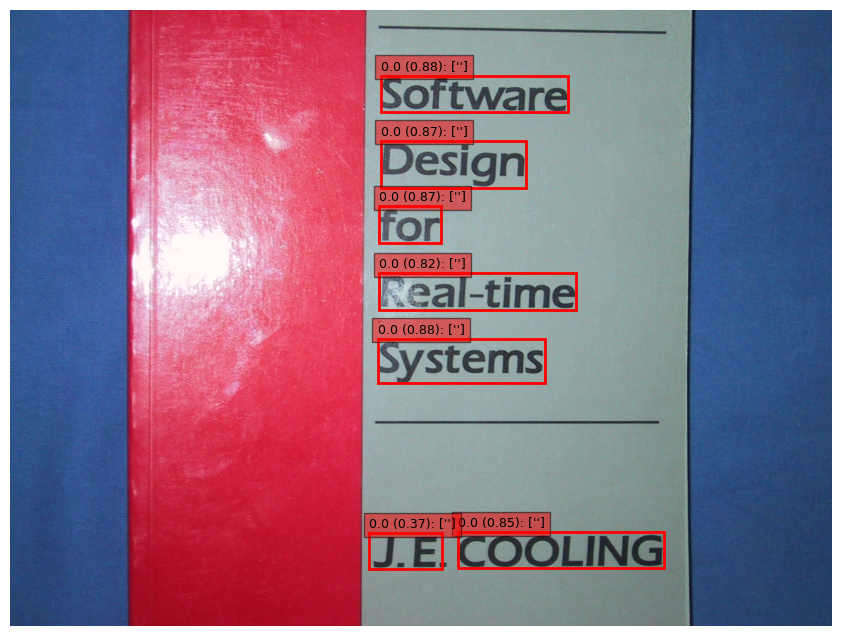

[([716.32080078125, 639.786376953125, 1041.536865234375, 727.013671875],
  0.0,
  0.8816049695014954,
  ['']),
 ([722.1292114257812, 127.49592590332031, 1086.6728515625, 198.53305053710938],
  0.0,
  0.8775473237037659,
  ['']),
 ([721.8336181640625, 254.5276641845703, 1004.790771484375, 345.4188537597656],
  0.0,
  0.8705151677131653,
  ['']),
 ([718.4617919921875, 382.14324951171875, 838.375732421875, 452.9566955566406],
  0.0,
  0.8685107827186584,
  ['']),
 ([871.273193359375, 1017.1292114257812, 1272.6767578125, 1086.056396484375],
  0.0,
  0.850264310836792,
  ['']),
 ([718.751708984375, 512.7526245117188, 1101.8572998046875, 584.1962280273438],
  0.0,
  0.8171765208244324,
  ['']),
 ([699.1517333984375, 1018.836181640625, 840.7908935546875, 1088.180908203125],
  0.0,
  0.36641794443130493,
  [''])]

In [62]:
predict('./datasets/yolo_data/test/images/IMG_1282.JPG', yolo, crnn_model, data_transforms, idx_to_char)